# **6 Boosted Decision Trees and Random Forest (Henry)**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def clean_nun(df):
    for name, column in df.iteritems():
        if np.sum(column.isnull()) > 0:
            df = df.drop(name, axis=1)
    return df

def data_renaming(df, renames_dict, features=None):
    if features is None:
        df = df.replace({**renames_dict})
    else:
        for i, feature in enumerate(features):
            df[feature] = df[feature].replace({**renames_dict[i]})
    return   df

dataRaw = pd.read_csv('Titanic.csv')

data = clean_nun(dataRaw)
renames = [{'male': 0, 'female' : 1}]
features = ['Sex']
data = data_renaming(data, renames, features)
splitB = round(len(data)/100*80)
dataTrain = data[:splitB]
dataTest = data[splitB:]
# to split randomly # not necessary, since the data is randomly distributed
# from sklearn.model_selection import train_test_split
# dataTrain, dataTest = train_test_split(data, test_size=0.2, random_state=1)

**6.2**

Training random forest and boosted decision tree models with default parameters.

Estimating the fitting time with timeit.

We can see, that with the default parameters adaBoost is ~2.3 times faster than random forest on
that particular set of data. It can be due to the number of estimators these methods use in sklearn
implementation: 100 as default for random forest and 50 for adaBoost. It correlates with the 2.3 ratio
between their times.

In [13]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import AdaBoostClassifier as abc
import timeit
xTrain = dataTrain.iloc[:, 1:]
yTrain = dataTrain['Survived']
xTest = dataTest.iloc[:, 1:]
yTest = dataTest['Survived']
rForest = rfc()
adaBoost = abc()
nCycles = 100
rForestTime = timeit.timeit('rForest.fit(xTrain, yTrain)', number=nCycles, globals=globals())
adaBoostTime = timeit.timeit('adaBoost.fit(xTrain, yTrain)', number=nCycles, globals=globals())
print(f'Total time (rForest, adaBoost): ({rForestTime},{adaBoostTime})')
print(f'Single cycle time (rForest, adaBoost):'
      f' ({rForestTime/nCycles},{adaBoostTime/nCycles})')
print(f'Ratio rForest/adaBoost: ({rForestTime/adaBoostTime})')

Total time (rForest, adaBoost): (9.791734300000002,4.161430800000005)
Single cycle time (rForest, adaBoost): (0.09791734300000002,0.04161430800000005)
Ratio rForest/adaBoost: (2.352972996691424)


**6.3**

K-Fold cross-validation for parameters tuning for the random forest algorithm. I am changing
the number of trees in the forest (n_estimators), the maximum depth of the tree (max_depth),
the minimum number of samples required to be at a leaf node (min_samples_leaf), and
the minimum number of samples required to split an internal node (min_samples_split).

The best score is achieved with n_estimators=50, max_depth=9, min_samples_split=3, min_samples_leaf=1.
The accuracy with these parameters on the test data is 0.84.

These parameters are different for different random states in the split between train and
test data.

In [10]:
from sklearn.model_selection import cross_val_score as cvs

n_estimators=[50, 100, 150]
max_depth=(7, 8, 9, 10)
min_samples_leaf=(1, 2, 3, 4)
min_samples_split=(2, 3, 4, 5)
max_score = 0
max_parameters = [50, 1, 1, 2]
for ne in n_estimators:
    print('ne', ne)
    for md in max_depth:
        # print('md', md)
        for msl in min_samples_leaf:
            # print('msl', msl)
            for mss in min_samples_split:
                # print('mss', mss)
                rForest = rfc(min_samples_split=mss, min_samples_leaf=msl,
                              max_depth=md, n_estimators=ne, random_state=1)
                score = cvs(rForest, xTrain, yTrain, cv=5).mean()
                if score > max_score:
                    max_score = score
                    max_parameters = [ne, md, msl, mss]
print(max_score, max_parameters)

In [6]:
rForest = rfc(min_samples_split=3, min_samples_leaf=1,
                              max_depth=9, n_estimators=50, random_state=1)
rForest.fit(xTrain, yTrain)
print(rForest.score(xTest, yTest))

NameError: name 'xTrain' is not defined

K-Fold cross-validation for parameters tuning for the AdaBoost.
I am changing the number of trees in the forest (n_estimators),
the maximum depth in the vase_estimator=DecisionTreeClassifier(max_depth), and
algorithm out of 'SAME' and 'SAME.R'.

The best score is achieved with n_estimators=50, max_depth=3, and algorithm='SAMME'.
Mean accuracy with these parameters on the test data is 0.83.

In [12]:
from sklearn.tree import DecisionTreeClassifier
n_estimators=[50, 75, 100]
max_depth=(1, 2, 3, 4, 5)
algorithm=('SAMME', 'SAMME.R')
rForest_scores = []
max_score = 0
max_parameters = [50, 1, 'SAMME']
score=0
for ne in n_estimators:
    # print('ne', ne)
    for md in max_depth:
        # print('md', md)
        for alg in algorithm:
            adaBoost = abc(base_estimator=DecisionTreeClassifier(max_depth=md),
               n_estimators=ne, algorithm=alg, random_state=1)
            score = cvs(adaBoost, xTrain, yTrain, cv=5).mean()
            if score > max_score:
                max_score = score
                max_parameters = [ne, md, alg]
print(max_score, max_parameters)

0.7994681374963065 [75, 5, 'SAMME']


In [138]:
adaBoost = abc(base_estimator=DecisionTreeClassifier(max_depth=5),
               n_estimators=75, algorithm='SAMME', random_state=1)
adaBoost.fit(xTrain, yTrain)
print(adaBoost.score(xTest, yTest))

0.8314606741573034


For practise I also have explored GridSearchCV from sklearn. I got the same result
as I had in the k-fold before for the random forest algorithm (same best parameters).
 And this one seems easier to use and it provides more info.

In [108]:
from sklearn.model_selection import GridSearchCV
parametersForest = {'n_estimators':[50, 100],

                    'max_depth':(6, 7, 8, 9),
                    'min_samples_split': (2, 3, 4, 5)
                    }
adaBoost = abc(random_state=1)
clf = GridSearchCV(rForest, parametersForest)
clf.fit(xTrain, yTrain)
# print(clf.cv_results_)
bestCase = clf.cv_results_['mean_test_score'].argmax()
print(clf.cv_results_['param_max_depth'][bestCase],
      clf.cv_results_['param_n_estimators'][bestCase],
      clf.cv_results_['param_min_samples_split'][bestCase])
rForest = rfc(max_depth=clf.cv_results_['param_max_depth'][bestCase],
              n_estimators=clf.cv_results_['param_n_estimators'][bestCase],
              min_samples_split=clf.cv_results_['param_min_samples_split'][bestCase],
              min_samples_leaf=1, random_state=1)
rForest.fit(xTrain, yTrain)
print(rForest.score(xTest, yTest))

9 50 3
0.8370786516853933


ROC curves and AUC for tuned models on the training set and test set.

We can see a slight difference in the performance of 2 methods. Overall,
performances of both methods on the test data are very similar, and ROC AUCs have very close values.

However, the curves may look different depending on the split between test and training data.

AUC=0.8831285202252943 (Random Forest (Train))
FPR=[0.        0.0437788 1.       ], TPR=[0.         0.81003584 1.        ]
AUC=0.8129054520358868 (Random Forest (Test))
FPR=[0.         0.10434783 1.        ], TPR=[0.         0.73015873 1.        ]
AUC=0.8966973886328726 (AdaBost (Train))
FPR=[0.         0.03456221 1.        ], TPR=[0.         0.82795699 1.        ]
AUC=0.8049689440993789 (AdaBoost (Test))
FPR=[0.         0.10434783 1.        ], TPR=[0.         0.71428571 1.        ]
AUC=0.8831285202252943 (Random Forest (Train))
FPR=[0.        0.0437788 1.       ], TPR=[0.         0.81003584 1.        ]
AUC=0.8129054520358868 (Random Forest (Test))
FPR=[0.         0.10434783 1.        ], TPR=[0.         0.73015873 1.        ]
AUC=0.8966973886328726 (AdaBoost (Train))
FPR=[0.         0.03456221 1.        ], TPR=[0.         0.82795699 1.        ]
AUC=0.8049689440993789 (AdaBoost (Test))
FPR=[0.         0.10434783 1.        ], TPR=[0.         0.71428571 1.        ]


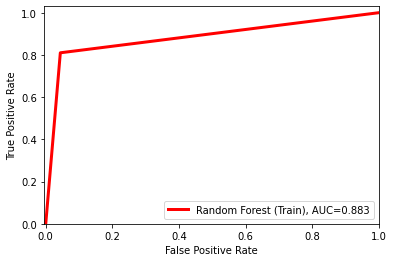

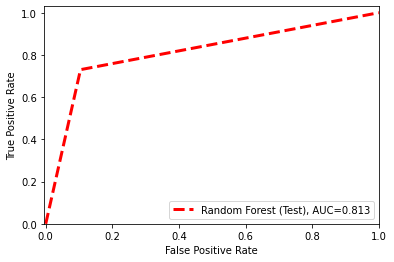

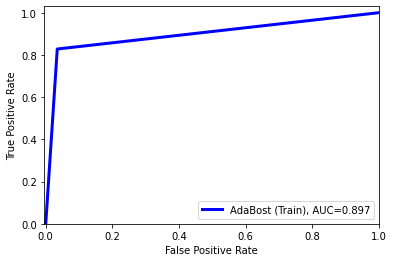

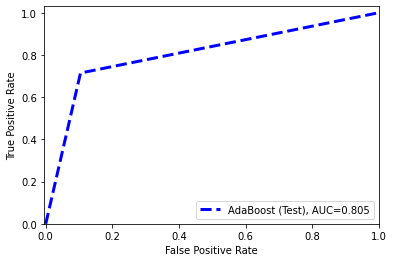

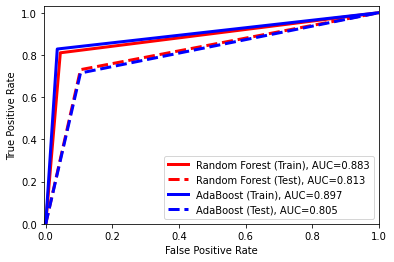

In [137]:
from sklearn.metrics import roc_curve, auc
def ROCdataPloting(values, score, name='', color='b', title='', ls='-', show=True):
    FPR, TPR, _ = roc_curve(values, score, pos_label=1)
    print(f'AUC={auc(FPR, TPR)} ({name})')
    print(f'FPR={FPR}, TPR={TPR}')
    plt.plot(FPR, TPR, lw=3, color=color,
             label=f'{name}, AUC={round(auc(FPR, TPR), 3)}', ls=ls)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.03])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    if show: plt.show()

rForest = rfc(min_samples_split=3, min_samples_leaf=1,
                              max_depth=9, n_estimators=50, random_state=1)
rForest.fit(xTrain, yTrain)
ROCdataPloting(yTrain, rForest.predict(xTrain), name='Random Forest (Train)', color='r')
ROCdataPloting(yTest, rForest.predict(xTest), name='Random Forest (Test)',
               color='r', ls='--')
adaBoost = abc(base_estimator=DecisionTreeClassifier(max_depth=5),
               n_estimators=75, algorithm='SAMME', random_state=1)
adaBoost.fit(xTrain, yTrain)
ROCdataPloting(yTrain, adaBoost.predict(xTrain), name='AdaBost (Train)', color='b')
ROCdataPloting(yTest, adaBoost.predict(xTest), name='AdaBoost (Test)',
               color='b', ls='--')
# all together
ROCdataPloting(yTrain, rForest.predict(xTrain), name='Random Forest (Train)', color='r', show=False)
ROCdataPloting(yTest, rForest.predict(xTest), name='Random Forest (Test)',
               color='r', ls='--', show=False)
ROCdataPloting(yTrain, adaBoost.predict(xTrain), name='AdaBoost (Train)', color='b', show=False)
ROCdataPloting(yTest, adaBoost.predict(xTest), name='AdaBoost (Test)',
               color='b', ls='--', show=True)

